In [1]:
import keras
import keras.backend as K
from keras import backend as K
from keras.models import Model, load_model

Using TensorFlow backend.


In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import glob
import pandas as pd
import re
import time
import os

In [3]:
def plot_2d_landmarks(img, true, pred):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    ax.imshow(img.reshape((80,120,3)).astype(np.float32))
    ax.autoscale(False)
    plt.plot(true[:,0], true[:,1], 'Pr', markersize=8)
    ax.plot(pred[:,0], pred[:,1], 'Dy', markersize=6)
    ax.axis('off')
    plt.show()
    

def plot_3d_landmarks(true, pred, gaze_vector):
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    Z = true
    ax.plot(np.hstack((Z[0:12,0], Z[0,0])) , np.hstack((Z[0:12,1], Z[0,1])), np.hstack((Z[0:12,2], Z[0,2])), c='r', marker='.')
    ax.plot(np.hstack((Z[12:20,0], Z[12,0])) , np.hstack((Z[12:20,1], Z[12,1])), np.hstack((Z[12:20,2], Z[12,2])), c='b', marker='.')
    ax.plot(np.hstack((Z[20:28,0], Z[20,0])) , np.hstack((Z[20:28,1], Z[20,1])), np.hstack((Z[20:28,2], Z[20,2])), c='g', marker='.')
    
    Z = np.vstack((np.mean(Z[20:28,:], axis=0), np.mean(Z[20:28,:], axis=0) - 0.1 * gaze_vector))
    ax.plot(Z[:,0], Z[:,1], Z[:,2], c='k', marker='^', linewidth=2.0)
    
    Z = pred
    ax.plot(np.hstack((Z[0:12,0], Z[0,0])) , np.hstack((Z[0:12,1], Z[0,1])), np.hstack((Z[0:12,2], Z[0,2])), c='r', marker='s', ls = 'dashed')
    ax.plot(np.hstack((Z[12:20,0], Z[12,0])) , np.hstack((Z[12:20,1], Z[12,1])), np.hstack((Z[12:20,2], Z[12,2])), c='b', marker='s', ls = 'dashed')
    ax.plot(np.hstack((Z[20:28,0], Z[20,0])) , np.hstack((Z[20:28,1], Z[20,1])), np.hstack((Z[20:28,2], Z[20,2])), c='g', marker='s', ls = 'dashed')
    
    ax.axis('off')
    plt.show()


def p_norm_loss(y_true, y_pred):
    return K.mean(K.pow(y_pred - y_true, 4), axis=-1)
    
def p_norm_loss(y_true, y_pred):
    return K.mean(K.pow(y_pred - y_true, 4), axis=-1)

def landmark_accuracy(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred) < 3.)
    
def landmark_accuracy_n(y_true, y_pred, n):
    diff = np.abs(y_true - y_pred)
    points = np.sum(diff, axis=2)
    mask = points < n
    return np.mean(points < n)

def landmark_loss(y_true, y_pred):
    return K.mean( K.square(y_true - y_pred) * K.sigmoid( 5 * (K.abs(y_true - y_pred) - 1) ), axis=-1)

def model_predict(model, test_inputs, num_samples, output_dims):
    t0 = time.time()
    pred = model.predict(test_inputs)
    print(time.time() - t0)
    return np.reshape(pred, (num_samples, 28, output_dims))

def load_model_and_predict(filepath, test_inputs, custom_objects, num_samples, output_dims=2):
    model = load_model(filepath, custom_objects)
    pred = model_predict(model, test_inputs, num_samples, output_dims)
    return model, pred

def load_all_models(model_type = 'augmented'):
    models = []
    
    for path in glob.glob('./models/%s/*.history' % model_type):
        with open(path, 'rb') as f:
            history = pickle.load(f)
            if len(history['val_loss']) == 70:
                model = load_model(path.replace('.history' , '.h5'), custom_objects)
                models.append((path, model, history))
        
    return models
        
def parse_model_desc(full_path):
    desc = re.findall(r'.*\\(.+).history', full_path)
    headpose, topology, dims, objective, losses = desc[0].split('-')
    return {'headpose': headpose,'topology': topology, 'dims': dims,'objective':  objective,'losses': losses}

In [4]:
# Initialization

# Load data
with open('all_data_augmented.pkl', 'rb') as f:
    images_train ,images_test, ldmks_2d_train , ldmks_2d_test , augmented_images_train, \
    augmented_images_test, augmented_ldmks_2d_train, augmented_ldmks_2d_test, ldmks_3d_train ,\
    ldmks_3d_test , head_pose_train ,head_pose_test, look_vec_train, look_vec_test = pickle.load(f)
    
with open('all_data_augmented_bw.pkl', 'rb') as f:
    bw_images_train , bw_images_test, _, _ , bw_augmented_images_train, \
    bw_augmented_images_test, _, _, _ , _ , _ ,_, _, _ = pickle.load(f)
    
# Params
num_samples = images_test.shape[0]
    
# Feed-forward params
test_inputs = {'input_img': images_test, 'head_pose': head_pose_test}
bw_test_inputs = {'input_img': bw_images_test, 'head_pose': head_pose_test}
augmented_test_inputs = {'input_img': augmented_images_test, 'head_pose': head_pose_test}
bw_augmented_test_inputs = {'input_img': bw_augmented_images_test, 'head_pose': head_pose_test}
all_test_inputs = {'input_img': np.vstack((images_test, augmented_images_test)), 'head_pose': np.vstack((head_pose_test, head_pose_test))}
bw_all_test_inputs = {'input_img': np.vstack((bw_images_test, bw_augmented_images_test)), 'head_pose': np.vstack((head_pose_test, head_pose_test))}

train_inputs = {'input_img': images_train, 'head_pose': head_pose_test}
bw_train_inputs = {'input_img': bw_images_train, 'head_pose': head_pose_test}
augmented_train_inputs = {'input_img': augmented_images_train, 'head_pose': head_pose_test}
bw_augmented_train_inputs = {'input_img': bw_augmented_images_train, 'head_pose': head_pose_test}
all_train_inputs = {'input_img': np.vstack((images_train, augmented_images_train)), 'head_pose': np.vstack((head_pose_test, head_pose_test))}
bw_all_train_inputs = {'input_img': np.vstack((bw_images_train, bw_augmented_images_train)), 'head_pose': np.vstack((head_pose_test, head_pose_test))}

custom_objects={'p_norm_loss': p_norm_loss, 'landmark_accuracy' : landmark_accuracy, 'landmark_loss': landmark_loss}

# Reshape for original dimensions for plotting
all_ldmks_2d_test = np.reshape(np.vstack((ldmks_2d_test, augmented_ldmks_2d_test)), (num_samples * 2, 28, 2))
ldmks_2d_test = np.reshape(ldmks_2d_test, (num_samples, 28, 2))
augmented_ldmks_2d_test = np.reshape(augmented_ldmks_2d_test, (num_samples, 28, 2))
ldmks_3d_test = np.reshape(ldmks_3d_test, (num_samples, 28, 3))

num_samples_train = images_train.shape[0]
all_ldmks_2d_train = np.reshape(np.vstack((ldmks_2d_train, augmented_ldmks_2d_train)), ( num_samples_train* 2, 28, 2))
ldmks_2d_train = np.reshape(ldmks_2d_train, (num_samples_train, 28, 2))
augmented_ldmks_2d_train = np.reshape(augmented_ldmks_2d_train, (num_samples_train, 28, 2))
# ldmks_3d_test = np.reshape(ldmks_3d_test, (num_samples, 28, 3))

head_pose_test_raw = np.reshape(head_pose_test, (num_samples, 3,3))

In [ ]:
# Load models
synthetic_models = load_all_models('synthetic')
transfer_models = load_all_models('transferlearning')
bw_models = load_all_models('bw')
augmented_models = load_all_models('augmented')
L3D_models = load_all_models('3D')

### Plotting

In [74]:
import pickle
import matplotlib.pyplot as plt
with open('models/bw/HeadFalse-spatial-2D-landmark_loss-[2.5580506541512231, 0.92953608587848857].history', 'rb') as f:
    history_landmark = pickle.load(f)
    
with open('models/bw/HeadFalse-spatial-2D-mean_absolute_error-[1.2376450350476191, 0.92612464138955786].history', 'rb') as f:
    history_mae = pickle.load(f)

with open('models/bw/HeadFalse-spatial-2D-mean_squared_error-[2.763318118998813, 0.93038304926901993].history', 'rb') as f:
    history_mse = pickle.load(f)

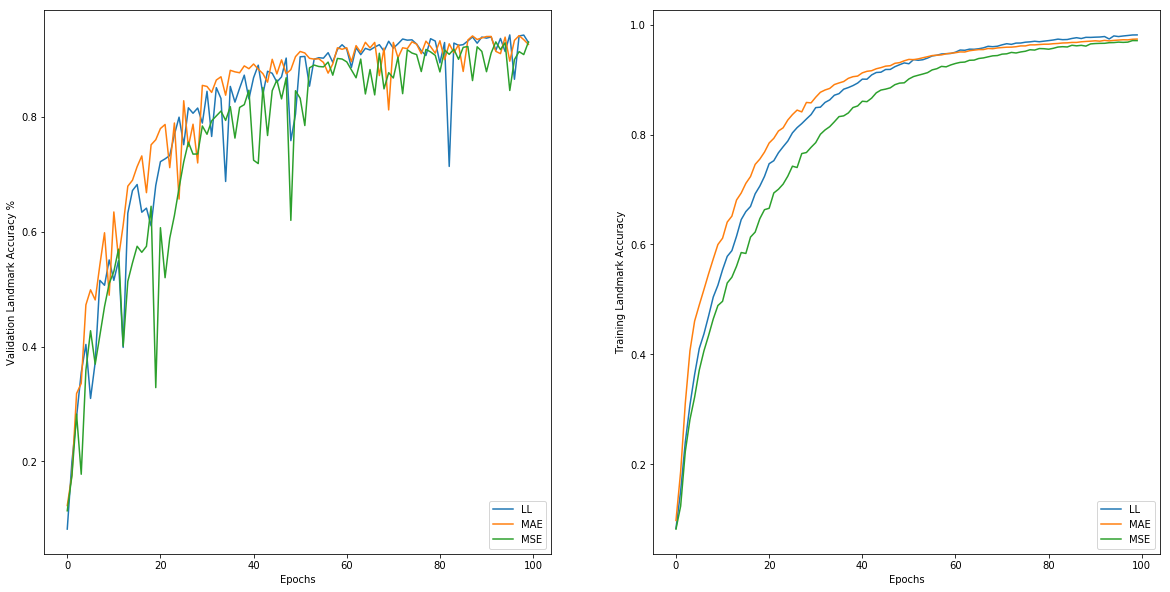

In [75]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(history_landmark['val_landmark_accuracy'], label='LL')
plt.plot(history_mae['val_landmark_accuracy'], label='MAE')
plt.plot(history_mse['val_landmark_accuracy'], label='MSE')

plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Validation Landmark Accuracy %')

plt.subplot(1,2,2)
plt.plot(history_landmark['landmark_accuracy'], label='LL')
plt.plot(history_mae['landmark_accuracy'], label='MAE')
plt.plot(history_mse['landmark_accuracy'], label='MSE')

plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Training Landmark Accuracy')
plt.show()

### Top model

In [6]:
def load_history(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

path = './models/bw/HeadFalse-spatial-2D-landmark_loss-[2.5580506541512231, 0.92953608587848857].h5'
model = load_model(path, custom_objects)
hist = load_history(path.replace('.h5', '.history'))

In [ ]:
preds_augmented_test = model_predict(model, bw_augmented_test_inputs, len(bw_augmented_test_inputs['input_img']), output_dims=2)
preds_synthetic_test = model_predict(model, bw_test_inputs, len(bw_test_inputs['input_img']), output_dims=2)
preds_all_test = model_predict(model, bw_all_test_inputs, len(bw_all_test_inputs['input_img']), output_dims=2)

preds_augmented_train = model_predict(model, bw_augmented_train_inputs, len(bw_augmented_train_inputs['input_img']), output_dims=2)
preds_synthetic_train = model_predict(model, bw_train_inputs, len(bw_train_inputs['input_img']), output_dims=2)
preds_all_train = model_predict(model, bw_all_train_inputs, len(bw_all_train_inputs['input_img']), output_dims=2)

print('Test results')
print('Augmented', landmark_accuracy_n(augmented_ldmks_2d_test, preds_augmented_test, 5))
print('Synthetic', landmark_accuracy_n(ldmks_2d_test, preds_synthetic_test, 5))
print('All', landmark_accuracy_n(all_ldmks_2d_test, preds_all_test, 5))

print('Training results')
print('Augmented', landmark_accuracy_n(augmented_ldmks_2d_train, preds_augmented_train, 5))
print('Synthetic', landmark_accuracy_n(ldmks_2d_train, preds_synthetic_train, 5))
print('All', landmark_accuracy_n(all_ldmks_2d_train, preds_all_train, 5))

1.8744843006134033
1.1320078372955322


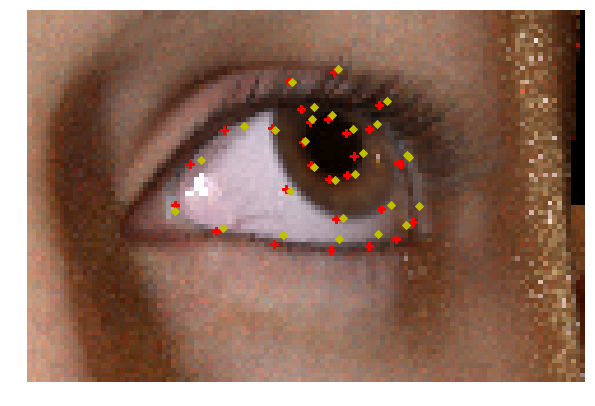

In [269]:
i = np.random.choice(len(preds_augmented))
plot_2d_landmarks(images_test[i,:,:,:], ldmks_2d_test[i,:,:], preds_synthetic[i,:,:])

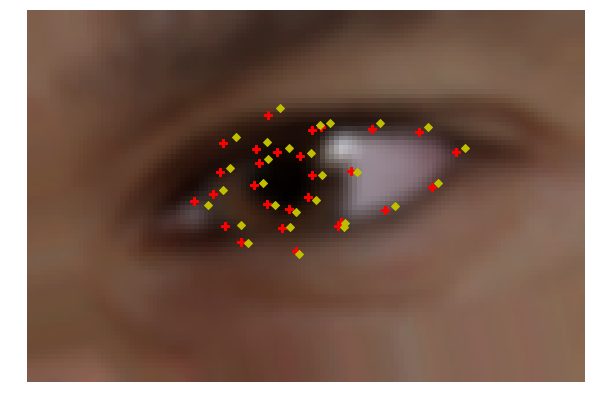

In [395]:
i = np.random.choice(len(preds_augmented))
plot_2d_landmarks(augmented_images_test[i,:,:,:], augmented_ldmks_2d_test[i,:,:], preds_augmented[i,:,:])

In [ ]:
window_sizes = list(range(1, 11))

augmented_sensitivity = [landmark_accuracy_n(augmented_ldmks_2d_test, preds_augmented, n) for n in window_sizes]
synthetic_sensitivity = [landmark_accuracy_n(ldmks_2d_test, preds_synthetic, n) for n in window_sizes]
all_sensitivity = [landmark_accuracy_n(all_ldmks_2d_test, preds_all, n) for n in window_sizes]

In [ ]:
plt.rcParams.update({'font.size': 16, 'font.family': 'Arial'})
plt.figure(figsize=(8,6))
plt.plot(window_sizes, 100 * np.array(augmented_sensitivity), label='Augmented')
plt.plot(window_sizes, 100* np.array(synthetic_sensitivity), label='Synthetic')
plt.plot(window_sizes, 100 * np.array(all_sensitivity), label='Combined')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
plt.xlabel('Window Size (Pixels)')
plt.ylabel('Landmark Accuracy %')
plt.show()

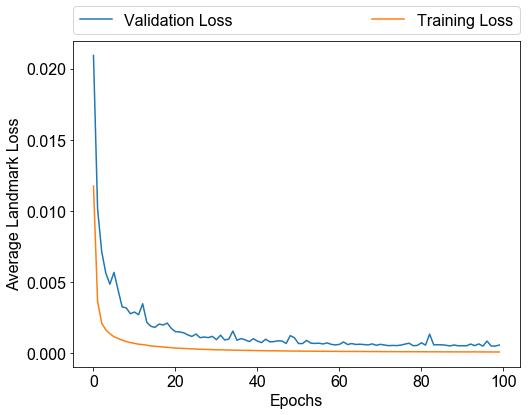

In [402]:
plt.figure(figsize=(8,6))
plt.plot(list(range(100)), np.array(hist['val_loss']) / len(all_ldmks_2d_test), label='Validation Loss')
plt.plot(list(range(100)), np.array(hist['loss']) / (len(images_train) * 2), label='Training Loss')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
plt.xlabel('Epochs')
plt.ylabel('Average Landmark Loss')
plt.show()

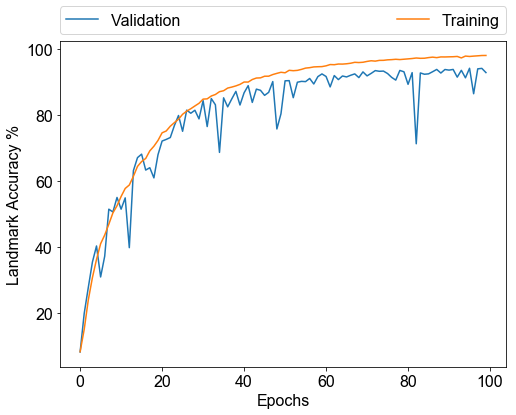

In [399]:
plt.figure(figsize=(8,6))
plt.plot(list(range(100)), 100 * np.array(hist['val_landmark_accuracy']) , label='Validation')
plt.plot(list(range(100)), 100 * np.array(hist['landmark_accuracy']) , label='Training')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
plt.xlabel('Epochs')
plt.ylabel('Landmark Accuracy %')
plt.show()

In [ ]:
def adaptive_accuracy(y_true, y_pred, ratio):

    score = []
    N = len(y_true)

    for i in range(N):
        lids = y_true[i,:12, 0] # x-values of lids
        diff = (max(lids) - min(lids)) * ratio

        pred = y_pred[i,:,:]
        true = y_true[i,:,:]

        score.append(landmark_accuracy_n(true[np.newaxis, :, :], pred[np.newaxis, :, :], diff))
        
    return np.mean(score)

In [ ]:
ratios = np.linspace(0.02, 0.2, 10)

augmented_sensitivity_adap = [adaptive_accuracy(augmented_ldmks_2d_test, preds_augmented, n) for n in ratios]
synthetic_sensitivity_adap = [adaptive_accuracy(ldmks_2d_test, preds_synthetic, n) for n in ratios]
all_sensitivity_adap = [adaptive_accuracy(all_ldmks_2d_test, preds_all, n) for n in ratios]

plt.rcParams.update({'font.size': 16, 'font.family': 'Arial'})
plt.figure(figsize=(8,6))
plt.plot(ratios * 100 , np.array(augmented_sensitivity_adap) * 100, label='Augmented')
plt.plot(ratios * 100, np.array(synthetic_sensitivity_adap )* 100, label='Synthetic')
plt.plot(ratios * 100, np.array(all_sensitivity_adap) * 100, label='Combined')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
plt.xlabel('Adaptive Window Size (% of Eye Width in Pixels)')
plt.ylabel('Landmark Accuracy %')
plt.show()

In [7]:
path = './models/bw/HeadFalse-spatial-2D-landmark_loss-[2.5580506541512231, 0.92953608587848857].h5'
model = load_model(path, custom_objects)
# hist = load_history(path.replace('.h5', '.history'))

In [8]:
with open('augment_test_img.pkl' , 'rb') as f:
    (image, ldmks_2d, ldmks_3d, head_pose, look_vec, transformed_img, transformed_ldmk) = pickle.load(f)

In [37]:
from skimage import color

inp1 = {'input_img': color.rgb2grey(image.reshape(80,120,3))[np.newaxis, np.newaxis, :,:], 'head_pose': head_pose}
pred1 = model.predict(inp1).reshape((28,2))

inp2 = {'input_img': color.rgb2grey(transformed_img.reshape(80,120,3))[np.newaxis, np.newaxis, :,:], 'head_pose': head_pose}
pred2 = model.predict(inp2).reshape((28,2))

ldmks_2d = ldmks_2d.reshape((28,2))
transformed_ldmk = transformed_ldmk.reshape((28,2))